In [32]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import random

from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from skimage.io import imread
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from time import time

(2964, 32, 32)

In [35]:
df = pd.read_csv("./train_set.csv")

In [36]:
df

,Unnamed: 0,id_img,paths,label
0,0,100,data\train\happy\100.jpg,happy
1,1,10000,data\train\happy\10000.jpg,happy
2,2,10001,data\train\happy\10001.jpg,happy
3,3,10005,data\train\happy\10005.jpg,happy
4,4,10035,data\train\happy\10035.jpg,happy
...,...,...,...,...
12097,12097,9966,data\train\sadness\9966.jpg,sadness
12098,12098,9974,data\train\sadness\9974.jpg,sadness
12099,12099,9976,data\train\sadness\9976.jpg,sadness
12100,12100,9986,data\train\sadness\9986.jpg,sadness


In [37]:
# Reemplazar '\\' por '/' en la columna 'paths'
df['paths'] = df['paths'].str.replace('\\', '/')

# Ahora todas las rutas en la columna 'paths' deberían tener '/' en lugar de '\\'



# Añadir 'data/' al inicio de todas las rutas en la columna 'paths'
df['paths'] = df['paths'].apply(lambda x: 'data/' + x)

# Ahora todas las rutas en la columna 'paths' deberían tener 'data/' al inicio

In [38]:
from sklearn.model_selection import train_test_split

# Dividir el DataFrame en características (paths) y etiquetas (label)
X = df['paths']
y = df['label']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear nuevos DataFrames para conjuntos de entrenamiento y prueba
train_df = pd.DataFrame({'paths': X_train, 'label': y_train})
test_df = pd.DataFrame({'paths': X_test, 'label': y_test})

# Imprimir la forma de los nuevos DataFrames
print("Forma del conjunto de entrenamiento:", train_df.shape)
print("Forma del conjunto de prueba:", test_df.shape)


Forma del conjunto de entrenamiento: (9681, 2)
Forma del conjunto de prueba: (2421, 2)


In [65]:
X_train


9060      data/data/train/sadness/2237.jpg
9095      data/data/train/sadness/2261.jpg
9750      data/data/train/sadness/2707.jpg
10020    data/data/train/sadness/28865.jpg
11835     data/data/train/sadness/8153.jpg
                       ...                
11964      data/data/train/sadness/902.jpg
5191       data/data/train/happy/33250.jpg
5390       data/data/train/happy/34209.jpg
860        data/data/train/happy/13964.jpg
7270     data/data/train/sadness/10711.jpg
Name: paths, Length: 9681, dtype: object

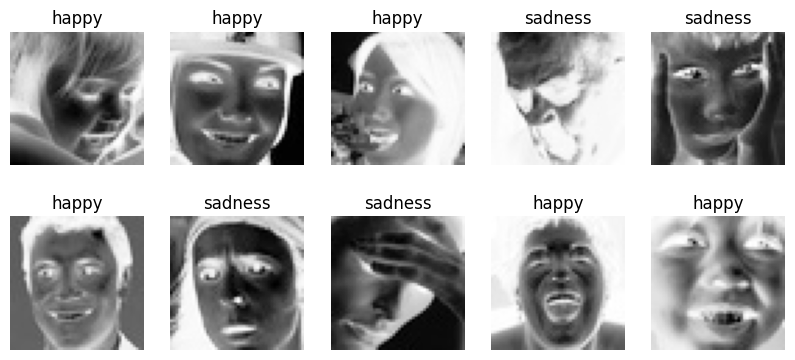

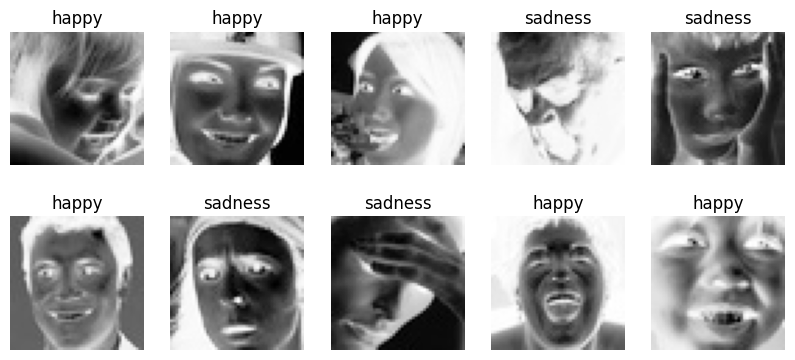

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def show_images_batch(df, indices, n_cols=5, size_scale=2):
    n_rows = ((len(indices) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1 * size_scale))
    for index, idx in enumerate(indices):
        plt.subplot(n_rows, n_cols, index + 1)
        img_path = df.iloc[idx]['paths']
        img_label = df.iloc[idx]['label']
        img = plt.imread(img_path)
        plt.imshow(img, cmap="Greys")
        plt.axis("off")
        plt.title(img_label)

def show_images_files(df, indices, n_cols=5, size_scale=2):
    n_rows = ((len(indices) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1 * size_scale))
    for index, idx in enumerate(indices):
        plt.subplot(n_rows, n_cols, index + 1)
        img_path = df.iloc[idx]['paths']
        img_label = df.iloc[idx]['label']
        img = plt.imread(img_path)
        plt.imshow(img, cmap="Greys")
        plt.axis("off")
        plt.title(img_label)

# Utiliza estos índices de ejemplo para mostrar una muestra de imágenes
indices = np.random.randint(0, len(df), 10)

# Mostrar imágenes utilizando el DataFrame
show_images_batch(df, indices)
show_images_files(df, indices)


In [40]:
pd.Series(y_train).value_counts(True)

label
happy      0.591055
sadness    0.408945
Name: proportion, dtype: float64

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os



# Crear generadores de datos para carga y preprocesamiento de imágenes
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='paths',
    y_col='label',
    target_size=(150, 150),  # ajustar al tamaño deseado de la imagen
    batch_size=32,
    class_mode='binary'  # porque solo hay dos clases: "sadness" y "happy"
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='paths',
    y_col='label',
    target_size=(150, 150),  # ajustar al tamaño deseado de la imagen
    batch_size=32,
    class_mode='binary'  # porque solo hay dos clases: "sadness" y "happy"
)

# Crear modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

# Evaluar el modelo
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)



Found 9681 validated image filenames belonging to 2 classes.
Found 2421 validated image filenames belonging to 2 classes.
Epoch 1/10


303/303 [==============================] - 102s 329ms/step - loss: 0.6407 - accuracy: 0.6271 - val_loss: 0.5821 - val_accuracy: 0.6811
Epoch 2/10
303/303 [==============================] - 97s 319ms/step - loss: 0.5249 - accuracy: 0.7293 - val_loss: 0.4947 - val_accuracy: 0.7518
Epoch 3/10
303/303 [==============================] - 97s 320ms/step - loss: 0.4435 - accuracy: 0.7880 - val_loss: 0.4348 - val_accuracy: 0.7893
Epoch 4/10
303/303 [==============================] - 97s 320ms/step - loss: 0.3836 - accuracy: 0.8234 - val_loss: 0.4321 - val_accuracy: 0.7947
Epoch 5/10
303/303 [==============================] - 97s 319ms/step - loss: 0.3205 - accuracy: 0.8567 - val_loss: 0.4250 - val_accuracy: 0.7993
Epoch 6/10
303/303 [==============================] - 97s 320ms/step - loss: 0.2580 - accuracy: 0.8894 - val_loss: 0.4207 - val_accuracy: 0.8083
Epoch

In [42]:
optimizer = keras.optimizers.Adam()

In [43]:
metrics = ["accuracy"] # dataset equilibrado
loss = "binary_crossentropy" # Es un clasificador binario

In [44]:
batch_size = 32 
len(X_train)/batch_size

302.53125

In [45]:
num_epochs = 100

In [46]:
earlyS = keras.callbacks.EarlyStopping(patience = 10)

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 128)      

In [52]:
# Evaluar el modelo utilizando el generador de prueba
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)


76/76 [==============================] - 7s 94ms/step - loss: 0.8997 - accuracy: 0.7844
Test accuracy: 0.7843866348266602


In [59]:
# Supongamos que y_train es una lista de etiquetas de entrenamiento
y_train = ["happy", "sadness", "happy", "sadness", "happy", "happy", "sadness", ...]

# Obtener un subconjunto de etiquetas de entrenamiento utilizando índices
subset_indices = np.array([1, 2, min(3560, len(y_train) - 1)])  # Índices de las etiquetas que quieres seleccionar, evitando índices fuera del rango
subset_y_train = [y_train[i] for i in subset_indices]

# Convertir las etiquetas seleccionadas a valores numéricos (0 para "happy", 1 para "sadness")
subset_y_train_num = np.array([0 if y == "happy" else 1 for y in subset_y_train])

# Imprimir el resultado
print("Etiquetas seleccionadas:", subset_y_train)
print("Etiquetas numéricas correspondientes:", subset_y_train_num)



Etiquetas seleccionadas: ['sadness', 'happy', Ellipsis]
Etiquetas numéricas correspondientes: [1 0 1]


In [60]:
def prepare_model(resolucion = (32,32)):
    layers = [
    keras.layers.Conv2D(64,(3,3), activation = 'relu', padding= "same",input_shape=(32,32,3)),
    keras.layers.MaxPooling2D(pool_size = (2,2), padding = "same"),
    keras.layers.Dropout(rate = 0.25),
    
    keras.layers.Conv2D(128,(3,3), activation = 'relu', padding= "same"),
    keras.layers.MaxPooling2D(pool_size = (2,2), padding = "same"),
    keras.layers.Dropout(rate = 0.25),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(rate = 0.5),
    keras.layers.Dense(1, activation='sigmoid')
    ]
    model = keras.Sequential(layers)
    optimizer = keras.optimizers.Adam()
    metrics = ["accuracy"] # dataset equilibrado
    loss = "binary_crossentropy" # Es un clasificador binario
    model.compile(optimizer= optimizer,
              loss= loss,
              metrics= metrics)
    return model
    

In [68]:
df2 = pd.read_csv("sample_submission.csv")
df2

,id_img,label
0,29622,sadness
1,6449,happy
2,2492,happy
3,33988,happy
4,19975,sadness
...,...,...
2959,9416,sadness
2960,10312,happy
2961,35804,happy
2962,21005,sadness


In [69]:
df3 = pd.read_csv("test_set.csv")

In [70]:
df3

,Unnamed: 0,id_img,paths
0,0,10019,data/test/10019.jpg
1,1,10023,data/test/10023.jpg
2,2,10074,data/test/10074.jpg
3,3,10096,data/test/10096.jpg
4,4,10106,data/test/10106.jpg
...,...,...,...
2959,2959,9864,data/test/9864.jpg
2960,2960,987,data/test/987.jpg
2961,2961,9885,data/test/9885.jpg
2962,2962,9889,data/test/9889.jpg


In [72]:
# Reemplazar '\\' por '/' en la columna 'paths'
df3['paths'] = df3['paths'].str.replace('\\', '/')

# Ahora todas las rutas en la columna 'paths' deberían tener '/' en lugar de '\\'



# Añadir 'data/' al inicio de todas las rutas en la columna 'paths'
df3['paths'] = df3['paths'].apply(lambda x: 'data/' + x)

# Ahora todas las rutas en la columna 'paths' deberían tener 'data/' al inicio

In [75]:
from PIL import Image
import numpy as np

# Lista para almacenar las imágenes preprocesadas
images = []

# Iterar sobre las rutas de las imágenes en df3 y cargarlas
for img_path in df3['paths']:
    # Cargar la imagen
    img = Image.open(img_path)
    # Redimensionar la imagen a (32, 32) para que coincida con el tamaño de entrada del modelo
    img = img.resize((32, 32))
    # Convertir la imagen a una matriz numpy y normalizar los valores de píxeles
    img_array = np.array(img) / 255.0
    # Agregar la imagen preprocesada a la lista
    images.append(img_array)

# Convertir la lista de imágenes a un array numpy
X_pred = np.array(images)



In [81]:
history = model.fit(X_pred, epochs=10,

Epoch 1/10


ValueError: in user code:

    File "c:\Users\adrif\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\adrif\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\adrif\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\adrif\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\adrif\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\adrif\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_5' (type Sequential).
    
    Input 0 of layer "conv2d_12" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 32, 32)
    
    Call arguments received by layer 'sequential_5' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 32, 32), dtype=float32)
      • training=True
      • mask=None
